# Supervised Learning Method (Classical Models)

---



## Data Preprocessing

### 1. Loading Data
- Load the MIMIC-IV dataset (hosp, icu, notes).

### 2. Feature Selection
- Select relevant features based on the defined digital phenotype.

### 3. Data Cleaning
- Remove outliers, handle missing data, and other noise.

### 4. Data Normalisation
- Standardise the scales for numerical features.
- Impute missing values particularly for important features

### 5. Label Encoding/Categorisation
- Convert categorical features to numerical values if needed.

### 6. Natural Language Processing (NLP)
- Extract and categorise insights from clinical notes.

### 7. Balance Datasets
- Handle significant class imbalance using Upsampling/Downsampling techniques
- E.g. SMOTE, class_weight

### 8. Train-Test Split
- Partition the dataset into training and testing sets.
- Stratify datasets

---

## Model Building

### 1. Model Selection
- Choose appropriate machine learning model(s) (e.g., Decision Trees, Random Forest, SVM).

### 2. Hyperparameter Tuning
- Fine-tune model hyperparameters using techniques like GridSearch or RandomSearch.

### 3. Feature Importance
- Evaluate and rank the importance of each feature.

### 4. Model Training
- Train the selected model on the training dataset.

---

## Model Evaluation

### 1. Validation Metrics
- Define metrics for evaluation (e.g., accuracy, precision, recall, F1-score).

### 2. Cross-Validation
- Apply cross-validation to assess model performance.

### 3. Performance Metrics
- Compute performance metrics on the testing set.

### 4. Confusion Matrix
- Generate a confusion matrix to evaluate class-wise performance.

### 5. ROC Curve
- Evaluate the Receiver Operating Characteristic (ROC) curve.

---


# Model Imports

In [ ]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# User options: 'Will', 'Chinatip'
# USER = "Will"
USER = "Azmi"

# Set up environment variables
if USER == 'Will':
    project_id = 'eighth-arbor-396212'
elif USER == 'Chinatip':
    project_id = 'ml-health-application'
elif USER == 'Azmi':
    project_id = "ml-health-395010"
else:
    project_id = None # FILL IN HERE

os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
dataset = 'mimiciv'


## Select All Patient Features

In [ ]:
BIG_QUERY = False

if BIG_QUERY:
    query = "SELECT * FROM `comp90089-hai-patients.hai_patients.patient_cohort_features` limit 3000"
    data = run_query(query)
else:
    from google.colab import drive
    drive.mount('/content/drive')

    file_path = ''
    if USER == 'Will':
        file_path = '/content/drive/My Drive/Colab Notebooks/COMP90089 Group Project Data/patient_cohort_features_vap.csv'
    elif USER == 'Azmi':
        file_path = '/content/drive/MyDrive/ML Health/proposal/patient_cohort_features_vap.csv'
    data = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning

In [ ]:
def check_null():
  #Check missing values
  print(data.isnull().sum(),"\n\n")

  #Check the type of data for each column. Notice that 'gender' is categorical (object) and 'dod' is time series.
  print(data.info())
check_null()

subject_id                             0
hadm_id                                0
stay_id                                0
duration_from_vap_device            7990
type__s__cmv                        7990
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 277, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 277 entries, subject_id to vent_o2_device-tracheostomy_tube
dtypes: float64(258), int64(2), object(17)
memory usage: 57.0+ MB
None


## Drop Columns

In [ ]:
import pandas as pd
from datetime import datetime

def is_datetime_col(series, sample_size=100):
    """Check if a pandas Series contains datetime-like values."""
    sample = series.dropna().sample(min(sample_size, series.count()))
    for item in sample:
        try:
            # Try to convert to datetime object
            datetime.strptime(str(item), '%Y-%m-%d %H:%M:%S %Z')
        except ValueError:
            return False
    return True

# Assume 'data' is your DataFrame
datetime_cols = []
for col in data.columns:
    if is_datetime_col(data[col]):
        datetime_cols.append(col)

# Drop datetime columns
data = data.drop(columns=datetime_cols)

print(f"Dropped the following datetime columns: {datetime_cols}")

Dropped the following datetime columns: ['abnormal_procalcitonin', 'abnormal_oxygen_levels_from_vap_lab', 'abnormal_wbc_count_from_vap_lab', 'belowavr_wbc_count_from_vap_lab', 'aboveavr_wbc_count_from_vap_lab', 'abnormal_c_reactive_protein_from_vap_lab', 'abnormal_procalcitonin_from_vap_lab', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']


In [ ]:
data.drop(['subject_id', 'hadm_id', 'stay_id', 'stay_id_1', 'admit_provider_id'], axis=1, inplace=True)


In [ ]:
# #drop records with unknown race and gender
# data = data[data['race'] != 'Unknown']
# data = data[data['gender'] != None]


# # Fill missing value with mean values
# data.fillna(data.mean(), inplace=True)
# data

In [ ]:
# Iterate over columns and apply the prefix and fill NaN with replacement value
for col in data.columns:
    if col.startswith("type_") or col.startswith("vent_type_") or col.startswith("value_") or col.startswith("vent_o2_device_"):
        data[col].fillna(0, inplace=True)
check_null()

duration_from_vap_device            7990
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        7215
vent_o2_device-nasal_cannula        7215
vent_o2_device-t-piece              7215
vent_o2_device-trach_mask_          7215
vent_o2_device-tracheostomy_tube    7215
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26974 entries, 0 to 26973
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 53.5+ MB
None


In [ ]:
# drop na and duplicate records
# data = data.dropna()
data = data.drop_duplicates()

# Remove na records
check_null()

duration_from_vap_device            4816
type__s__cmv                           0
type_aprv                              0
type_aprv_biphasic_apnpress            0
type_aprv_biphasic_apnvol              0
                                    ... 
vent_o2_device-high_flow_neb        4257
vent_o2_device-nasal_cannula        4257
vent_o2_device-t-piece              4257
vent_o2_device-trach_mask_          4257
vent_o2_device-tracheostomy_tube    4257
Length: 260, dtype: int64 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17860 entries, 0 to 26968
Columns: 260 entries, duration_from_vap_device to vent_o2_device-tracheostomy_tube
dtypes: float64(249), object(11)
memory usage: 35.6+ MB
None


## Data Normalisation & Label Encoding/Categorisation

In [ ]:
type_df = data.applymap(type)

string_columns = []
for col in type_df.columns:
    if (type_df[col] == str).any():
        string_columns.append(col)

print(f"Columns with at least one string element: {string_columns}")

Columns with at least one string element: ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'gender', 'anchor_year_group', 'dod', 'HAI_category']


#### Transform DOD Feature

In [ ]:
data['died'] = data['dod'].notna()

data.drop('dod', axis=1, inplace=True)

### Label Encoding

In [ ]:
data = pd.get_dummies(data, columns=['admission_type', 'race', 'gender', 'insurance', 'admission_type', 'admission_location', 'discharge_location', 'language', 'marital_status', 'anchor_year_group'])

# Create a LabelEncoder instance
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# fill missing value with mean
data.fillna(data.mean(), inplace=True)

<ipython-input-11-baf6b1632119>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


### Data Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

X = data.drop("HAI_category", axis=1)
y = data["HAI_category"]

# Fit and transform the scaler on the DataFrame
X_normalised = scaler.fit_transform(X)

# Create a new DataFrame with the normalized values
X_normalised = pd.DataFrame(X_normalised, columns=X.columns)

# remove duplicate features
X_normalised = X_normalised.loc[:,~X_normalised.columns.duplicated()].copy()

# Model Building


### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalised, y, test_size=0.2, random_state=42, stratify=y)

y_train[y_train == 'HAP'] = 1
y_train[y_train == 'No HAI'] = 0
y_train = y_train.astype('int')

y_test[y_test == 'HAP'] = 1
y_test[y_test == 'No HAI'] = 0
y_test = y_test.astype('int')

### Feature Selection

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE

X_train_ori = X_train.copy()
y_train_ori = y_train.copy()

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# divide by feature type
sensitive_columns = []
vital_columns = []
ventilator_columns = []

for col in X_train.columns:
  filtered = False

  # filter sensitive column
  for c in ['admission_type', 'race', 'gender', 'insurance', 'admission_type', 'admission_location',
            'discharge_location', 'language', 'marital_status', 'anchor_year_group', 'died']:
    if c in col:
      filtered = True
      sensitive_columns.append(col)

  for c in ["duration_from_vap_device", "vent_", "o2_flow", "respiratory_rate_", "ute_volume", # minute_volume
            "tidal_volume_", "plateau_pressure", "peep", "fio2", "flow_rate"]:
      if c in col:
        filtered = True
        ventilator_columns.append(col)

  # filter vital columns
  if not filtered and "value_" not in col and "type_" not in col:
    vital_columns.append(col)


# divide training & testing data based on feature type
X_train_sensitive = X_train[sensitive_columns]
X_train_vital = X_train[vital_columns]
X_train_ventilator = X_train[ventilator_columns]
X_test_sensitive = X_test[sensitive_columns]
X_test_vital = X_test[vital_columns]
X_test_ventilator = X_test[ventilator_columns]


### Evaluate Function

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    # Predict the labels
    y_pred = model.predict(X_test)

    __evaluate_model(y_pred, y_test)


def __evaluate_model(y_pred, y_test):
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of the final model: {accuracy:.2f}')

    # Compute the ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='macro')
    print(f'Multi-class ROC-AUC score: {roc_auc:.2f}')

    # Print classification report
    print(classification_report(y_test, y_pred))

### Random Forest Feature Importance

In [ ]:
def rf_feature_importance(rf, X):
  # Get feature importances
  importances = rf.feature_importances_

  # Create a DataFrame for the importances
  feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

  # Sort the DataFrame by the importances
  feature_importances = feature_importances.sort_values('importance', ascending=False)

  # Plotting the feature importances
  plt.figure(figsize=(12, 6))
  plt.title('Feature Importances')
  plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
  plt.gca().invert_yaxis()
  plt.show()

  # You can choose to keep only the most important features based on a certain threshold or top N features
  important_features = feature_importances[feature_importances['importance'] > 0.001]['feature']
  # important_features = feature_importances['feature'][:20]
  return important_features

### Train Model

Accuracy of the final model: 0.75
Multi-class ROC-AUC score: 0.53
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2646
           1       0.59      0.07      0.12       926

    accuracy                           0.75      3572
   macro avg       0.67      0.53      0.49      3572
weighted avg       0.71      0.75      0.66      3572



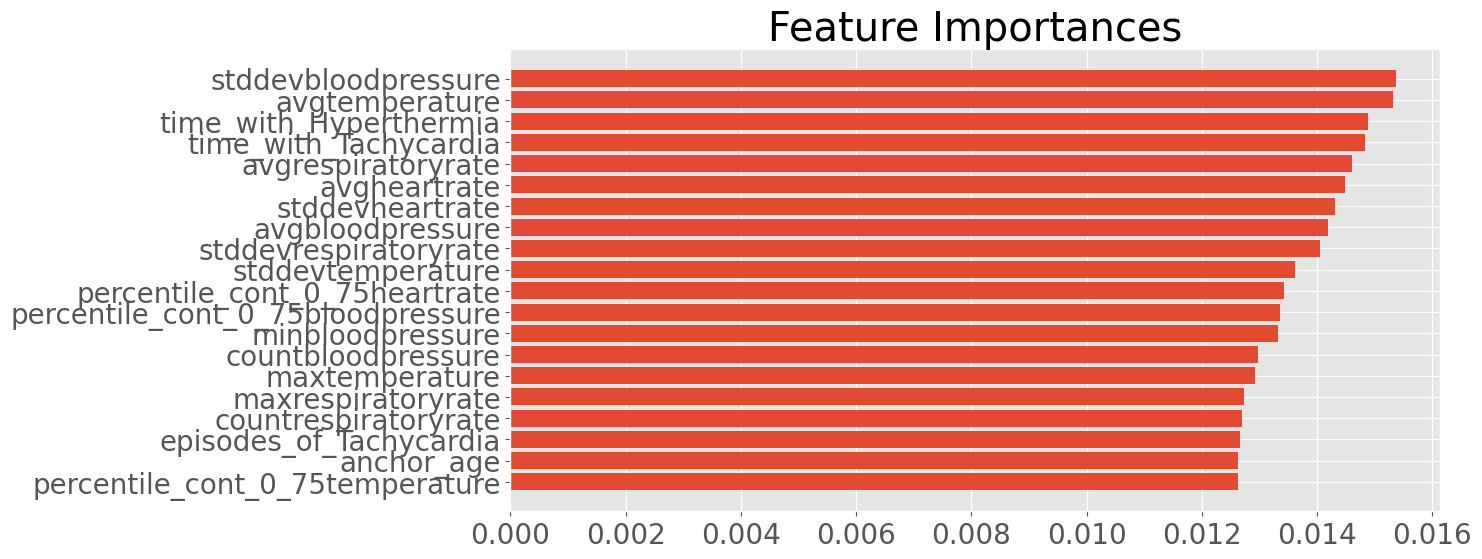

In [ ]:
# random forest (ori)
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_ori = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_ori.fit(X_train_ori, y_train_ori)

evaluate_model(rf_ori, X_test, y_test)

ori_important_features = rf_feature_importance(rf_ori, X_train_ori)

In [ ]:
len(list(ori_important_features))

157

In [ ]:
# naive bayes (ori)
from sklearn.naive_bayes import GaussianNB

X_train_ori_filtered = X_train_ori[ori_important_features]
X_test_filtered = X_test[ori_important_features]

# create model
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train_ori_filtered, y_train_ori)

evaluate_model(gnb, X_test_filtered, y_test)

Accuracy of the final model: 0.30
Multi-class ROC-AUC score: 0.51
              precision    recall  f1-score   support

           0       0.79      0.08      0.15      2646
           1       0.26      0.94      0.41       926

    accuracy                           0.30      3572
   macro avg       0.53      0.51      0.28      3572
weighted avg       0.66      0.30      0.22      3572



In [ ]:
# SVM RBF (ori)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
clf.fit(X_train_ori_filtered, y_train_ori)

evaluate_model(clf, X_test_filtered, y_test)

Accuracy of the final model: 0.74
Multi-class ROC-AUC score: 0.51
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      2646
           1       0.64      0.04      0.07       926

    accuracy                           0.74      3572
   macro avg       0.69      0.51      0.46      3572
weighted avg       0.72      0.74      0.65      3572



In [ ]:
# RF (undersampling)
from imblearn.under_sampling import RandomUnderSampler

# Initialize the undersampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the data
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_ori_filtered, y_train_ori)

# Create the Random Forest model
rf_under = RandomForestClassifier(n_estimators=100, random_state=42)

# rf_under the model
rf_under.fit(X_train_undersampled, y_train_undersampled)

evaluate_model(rf_under, X_test_filtered, y_test)

Accuracy of the final model: 0.62
Multi-class ROC-AUC score: 0.61
              precision    recall  f1-score   support

           0       0.81      0.64      0.71      2646
           1       0.36      0.58      0.44       926

    accuracy                           0.62      3572
   macro avg       0.58      0.61      0.58      3572
weighted avg       0.69      0.62      0.64      3572



In [ ]:
# RF (SMOTE undersampling)
# from imblearn.over_sampling import SMOTE

# # Initialize SMOTE
# smote = SMOTE(sampling_strategy='not minority', random_state=42)

# # Fit and transform the data
# X_train_undersampled, y_train_undersampled = smote.fit_resample(X_train_ori_filtered, y_train_ori)

# # Create the Random Forest model
# rf_under = RandomForestClassifier(n_estimators=100, random_state=42)

# # rf_under the model
# rf_under.fit(X_train_undersampled, y_train_undersampled)

# evaluate_model(rf_under, X_test_filtered, y_test)

In [ ]:
# RF (SMOTE oversampling)
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit and transform the data
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_ori_filtered, y_train_ori)

# Create the Random Forest model
rf_over = RandomForestClassifier(n_estimators=100, random_state=42)

# rf_under the model
rf_over.fit(X_train_oversampled, y_train_oversampled)

evaluate_model(rf_over, X_test_filtered, y_test)

Accuracy of the final model: 0.73
Multi-class ROC-AUC score: 0.56
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      2646
           1       0.45      0.21      0.29       926

    accuracy                           0.73      3572
   macro avg       0.61      0.56      0.56      3572
weighted avg       0.69      0.73      0.69      3572



In [ ]:
# RF (hybrid)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Define the under-sampling and over-sampling methods
under = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=0)  # Reduce majority class to 4500
over = SMOTE(sampling_strategy={1: 5000}, random_state=0)  # Increase minority class to 4500

# Define pipeline
pipeline = Pipeline(steps=[('u', under), ('o', over)])

# Apply the pipeline to the training data
X_train_hybrid_sampled, y_train_hybrid_sampled = pipeline.fit_resample(X_train_ori_filtered, y_train_ori)

# Create the Random Forest model
rf_hybrid = RandomForestClassifier(n_estimators=100, random_state=42)

# rf_under the model
rf_hybrid.fit(X_train_hybrid_sampled, y_train_hybrid_sampled)

evaluate_model(rf_hybrid, X_test_filtered, y_test)

Accuracy of the final model: 0.67
Multi-class ROC-AUC score: 0.61
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2646
           1       0.39      0.50      0.44       926

    accuracy                           0.67      3572
   macro avg       0.60      0.61      0.60      3572
weighted avg       0.70      0.67      0.68      3572



In [ ]:
# Define the under-sampling and over-sampling methods
under = RandomUnderSampler(sampling_strategy={0: 8000}, random_state=0)  # Reduce majority class to 8000
over = SMOTE(sampling_strategy={1: 5000}, random_state=0)  # Increase minority class to 5000

# Define pipeline
pipeline = Pipeline(steps=[('u', under), ('o', over)])

# Apply the pipeline to the training data
X_train_hybrid_sampled, y_train_hybrid_sampled = pipeline.fit_resample(X_train_ori_filtered, y_train_ori)

# class weight model
class_weights = {0: 5, 1: 8}

final_rf_weighted = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
final_rf_weighted.fit(X_train_hybrid_sampled, y_train_hybrid_sampled)

evaluate_model(final_rf_weighted, X_test_filtered, y_test)

Accuracy of the final model: 0.73
Multi-class ROC-AUC score: 0.55
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      2646
           1       0.45      0.18      0.25       926

    accuracy                           0.73      3572
   macro avg       0.60      0.55      0.54      3572
weighted avg       0.68      0.73      0.68      3572



### Ensemble Models

#### Sensitive Feature Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_sensitive = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_sensitive.fit(X_train_sensitive, y_train)

evaluate_model(rf_sensitive, X_test_sensitive, y_test)

In [ ]:
sensitive_features = rf_feature_importance(rf_sensitive, X_train_sensitive)

#### Vital Feature Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_vital = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_vital.fit(X_train_vital, y_train)

evaluate_model(rf_vital, X_test_vital, y_test)

In [ ]:
vital_features = rf_feature_importance(rf_vital, X_train_vital)

#### Ventilator Feature Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_ventilator = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_ventilator.fit(X_train_ventilator, y_train)

evaluate_model(rf_ventilator, X_test_ventilator, y_test)

In [ ]:
ventilator_features = rf_feature_importance(rf_ventilator, X_train_ventilator)

### Ensemble Model

In [ ]:
# create train & test data for voting
pred_ensemble_test = pd.DataFrame({
    "sensitive_soft": rf_sensitive.predict_proba(X_test_sensitive)[:, 1],
    "sensitive_hard": rf_sensitive.predict(X_test_sensitive),
    "vital_soft": rf_vital.predict_proba(X_test_vital)[:, 1],
    "vital_hard": rf_vital.predict(X_test_vital),
    "ventilator_soft": rf_ventilator.predict_proba(X_test_ventilator)[:, 1],
    "ventilator_hard": rf_ventilator.predict(X_test_ventilator),
})

# create train & test data for voting
pred_ensemble_train = pd.DataFrame({
    "sensitive_soft": rf_sensitive.predict_proba(X_train_sensitive)[:, 1],
    "sensitive_hard": rf_sensitive.predict(X_train_sensitive),
    "vital_soft": rf_vital.predict_proba(X_train_vital)[:, 1],
    "vital_hard": rf_vital.predict(X_train_vital),
    "ventilator_soft": rf_ventilator.predict_proba(X_train_ventilator)[:, 1],
    "ventilator_hard": rf_ventilator.predict(X_train_ventilator),
})

#### Simple Voting (Hard)

In [ ]:
y_pred = (pred_ensemble_test["sensitive_hard"] + pred_ensemble_test["vital_hard"] + pred_ensemble_test["ventilator_hard"]) / 3
y_pred = np.round(y_pred)
__evaluate_model(y_pred, y_test)

#### Simple Voting (Soft)

In [ ]:
y_pred = (pred_ensemble_test["sensitive_soft"] + pred_ensemble_test["vital_soft"] + pred_ensemble_test["ventilator_soft"]) / 3
y_pred = np.round(y_pred)
__evaluate_model(y_pred, y_test)

#### Weighted Voting (SVM)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
clf.fit(pred_ensemble_train, y_train)

evaluate_model(clf, pred_ensemble_test, y_test)

#### Weighted Voting (RF)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_ensemble = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_ensemble.fit(pred_ensemble_train, y_train)

evaluate_model(rf_ensemble, pred_ensemble_test, y_test)

#### Important Features + Vote

In [ ]:
X_ensemble_train = {}
X_ensemble_test = {}

# add important sensitive features
for col in sensitive_features.unique():
  X_ensemble_train[col] = list(X_train[col])
  X_ensemble_test[col] = list(X_test[col])

# add important vital features
for col in vital_features.unique():
  X_ensemble_train[col] = list(X_train[col])
  X_ensemble_test[col] = list(X_test[col])

# add important ventilator features
for col in ventilator_features.unique():
  X_ensemble_train[col] = list(X_train[col])
  X_ensemble_test[col] = list(X_test[col])

# voting result
for col in pred_ensemble_train.columns:
  # print(col, len(pred_ensemble_train[col]))
  X_ensemble_train[col] = list(pred_ensemble_train[col])
  X_ensemble_test[col] = list(pred_ensemble_test[col])


X_ensemble_train = pd.DataFrame(X_ensemble_train)
X_ensemble_test = pd.DataFrame(X_ensemble_test)

X_ensemble_train

Classifier

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_ensemble_train, y_train)

evaluate_model(xgb_model, X_ensemble_test, y_test)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma='auto'))
clf.fit(X_ensemble_train, y_train)

evaluate_model(clf, X_ensemble_test, y_test)